# Basis Function Regression con Kernel

### Autor: Carlos Andrés Arroyave
### Fecha : 27 Agosto 2025
### Mail :  caarroyave1@correo.iue.edu.co
### Movil : 3015813032
### Actividad :  Proyecto final , punto numero uno



## Importar librerias
Las siguientes lineas listan las librerias utilizadas en el desarrollo


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                           f1_score, roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('ggplot')
sns.set_palette("husl")

# Analisis del dataset Skin_NonSkin.txt

Lo primero que se realiza es cargar el archivo a un dataFrame para identificar y hacer un analisis exploratorio

Luego se utiliza el metodo .info  para obtener información de las varibles e identificar los tipos de datos

Se utiliza el metodo .shape para conocer el tamaño del arreglo, para este caso tendremos (245057, 4)

Finalmente se usa el metodo describe para identificar los Features y Targe. --->>> Las tres primeras variables son los features. La ultima variable es el Targe.

Finalmente haciendo uso del metodo groupby se identifica que los target solo tienen dos clasificadores.  1 y 2 

1 -->>    50859

2  -->>  194198

# Analisis exploratorio

Luego de cargar los datos se debe revisar los valores faltantes y outliers
Se sugiere utilizar graficas como Histogramas y graficos de dispersión


# Procesamiento Datos 

Limpieza:  Eliminar duplicados y aplicar medianas para los valores faltantes

Normalizar /Estandarizar: Calcular modas, medianas, desviaciones para clasificar los datos 

Dividir datos: utilizar la tecnica del 70-30 . Separamos los datos en 70% entrenamiento y 30% de test. Para eso utilizamos sklear con el metodo fit. 

Correlaciones:  Se realiza por medio de sklearn la identificación de la correlación que haya entre cada uno de las variables.

# Identificación del modelo
El modelo a utlizar para este DataSet es un modelo de regresión logistica, los datos pueden ser separables y clasificables rapidamente en dos categorias, adicionalmente tiene una buena distribucion de los datos


In [2]:
# Cargar datos
def load_data(filename):
    """Cargar datos desde archivo txt"""
    column_names = ['B', 'G', 'R', 'Label']  # Nota: el archivo tiene orden B, G, R
    df = pd.read_csv(filename, sep='\t', header=None, names=column_names)
    
    # Reordenar columnas para tener R, G, B
    df = df[['R', 'G', 'B', 'Label']]
    
    # Convertir etiqueta: 1 = piel, 2 = no-piel -> 0 = no-piel, 1 = piel
    df['Label'] = df['Label'].apply(lambda x: 1 if x == 1 else 0)
    
    return df

# Cargar datos
df = load_data('Skin_NonSkin.txt')
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())
print("\nInformación del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())

Dimensiones del dataset: (245057, 4)

Primeras 5 filas:
     R   G   B  Label
0  123  85  74      1
1  122  84  73      1
2  121  83  72      1
3  119  81  70      1
4  119  81  70      1

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245057 entries, 0 to 245056
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   R       245057 non-null  int64
 1   G       245057 non-null  int64
 2   B       245057 non-null  int64
 3   Label   245057 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB
None

Estadísticas descriptivas:
                   R              G              B          Label
count  245057.000000  245057.000000  245057.000000  245057.000000
mean      123.177151     132.507327     125.065446       0.207539
std        72.562165      59.941197      62.255653       0.405546
min         0.000000       0.000000       0.000000       0.000000
25%        70.000000      87.000000      68.000000       0.

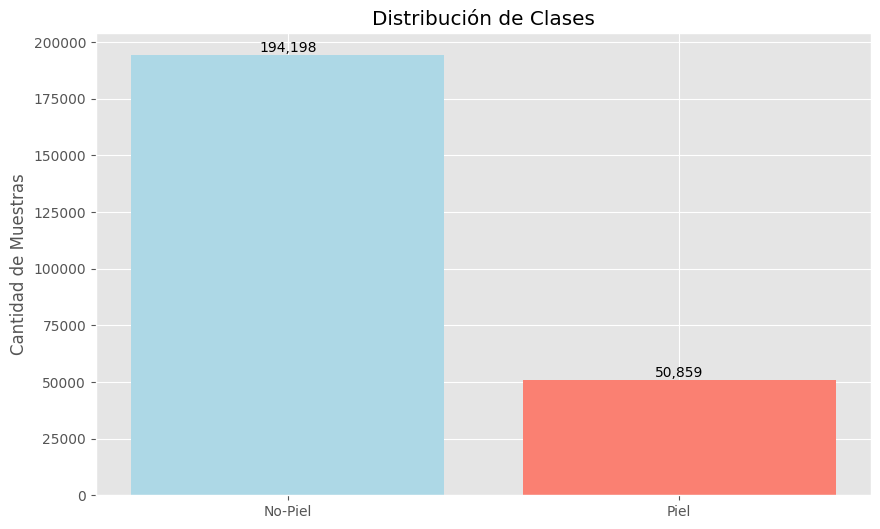

Proporción de clases: Piel 20.75%, No-Piel 79.25%


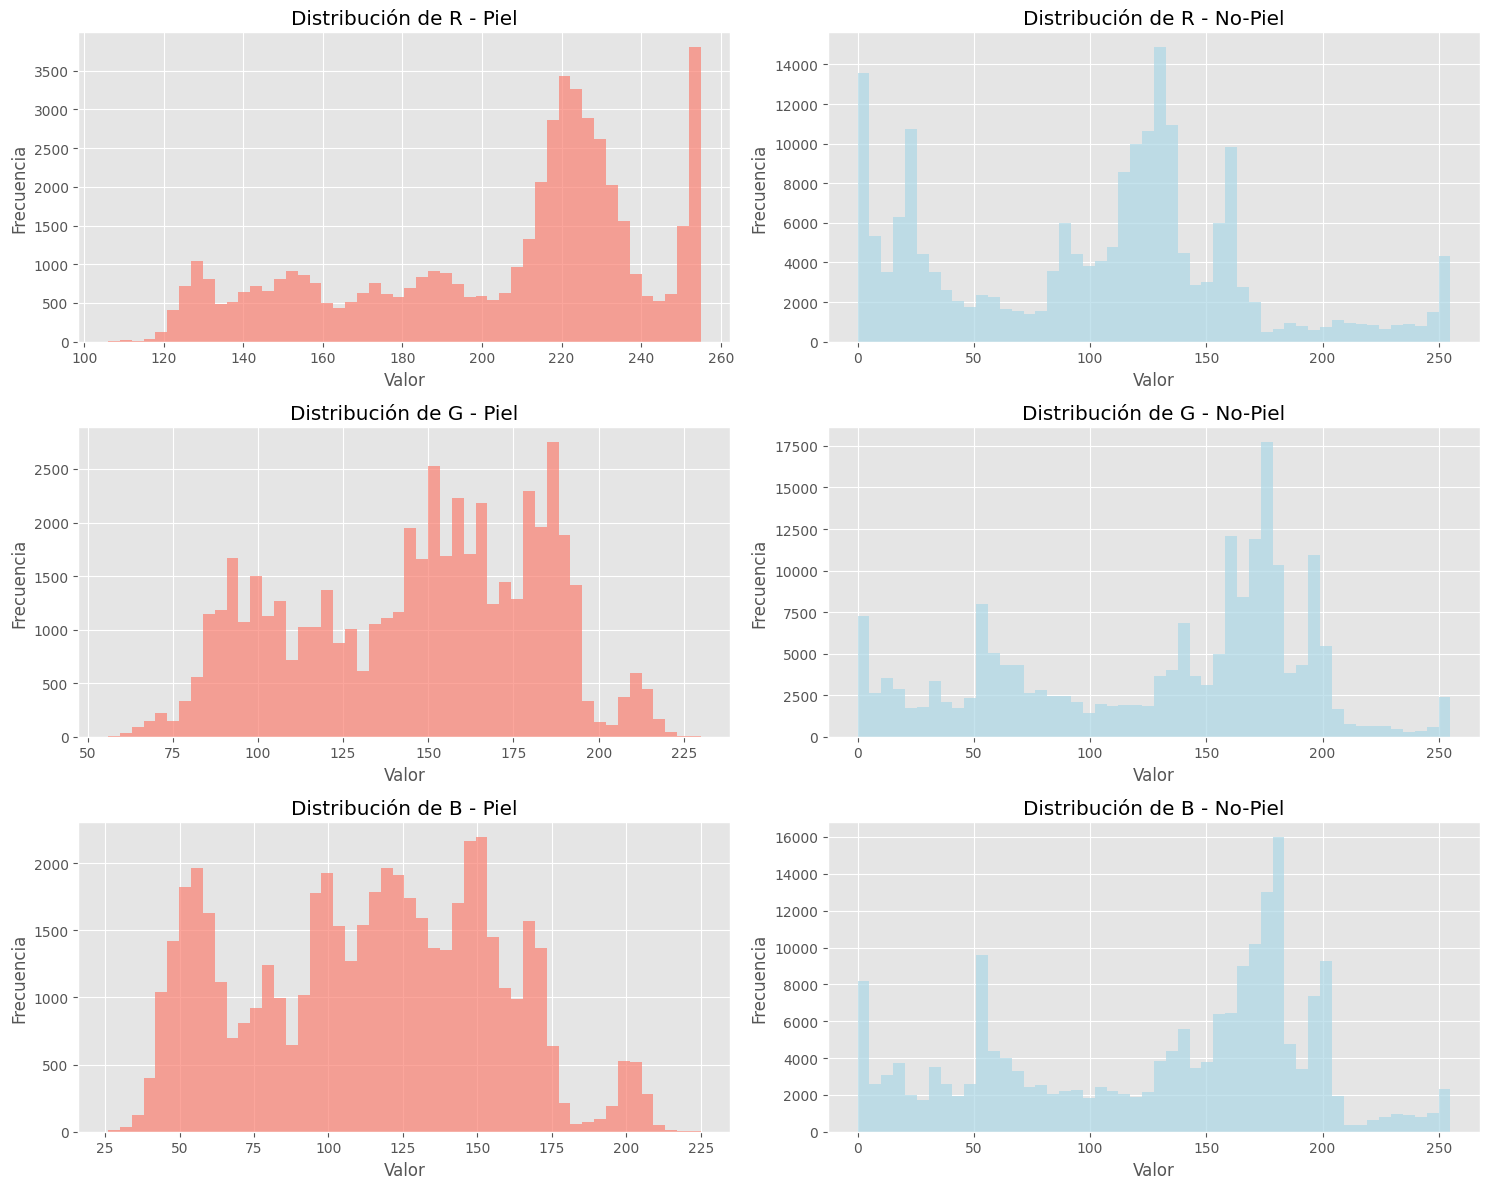

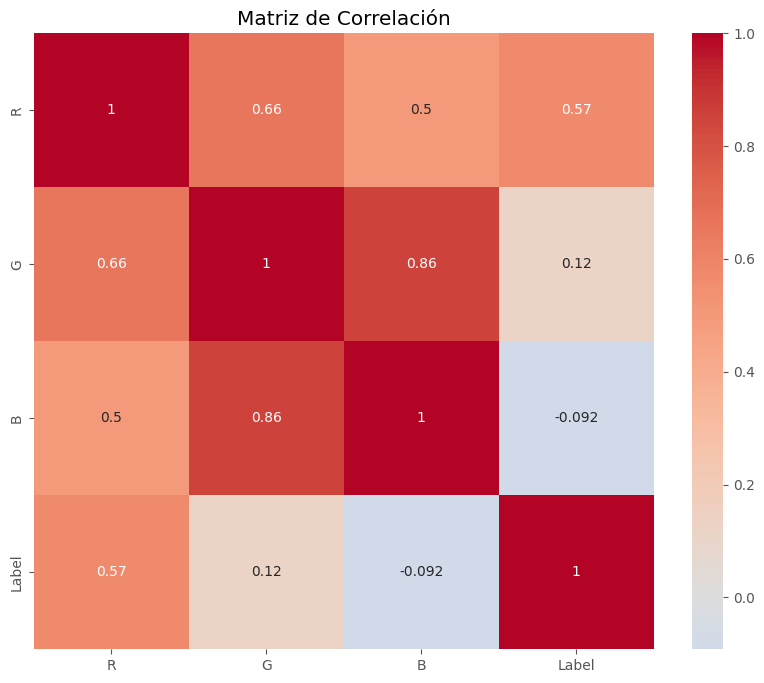

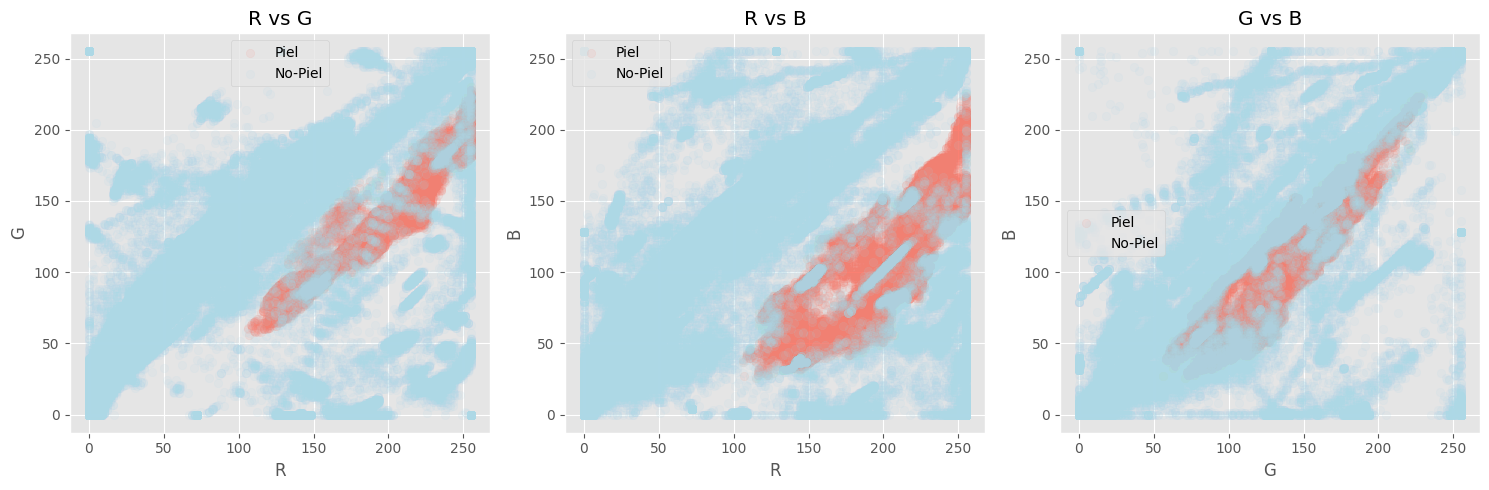

In [3]:
# Distribución de clases
plt.figure(figsize=(10, 6))
class_counts = df['Label'].value_counts()
plt.bar(['No-Piel', 'Piel'], class_counts.values, color=['lightblue', 'salmon'])
plt.title('Distribución de Clases')
plt.ylabel('Cantidad de Muestras')
plt.text(0, class_counts[0], f'{class_counts[0]:,}', ha='center', va='bottom')
plt.text(1, class_counts[1], f'{class_counts[1]:,}', ha='center', va='bottom')
plt.show()

print(f"Proporción de clases: Piel {class_counts[1]/len(df)*100:.2f}%, No-Piel {class_counts[0]/len(df)*100:.2f}%")

# Histogramas de canales de color por clase
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
colors = ['R', 'G', 'B']

for i, color in enumerate(colors):
    # Piel
    axes[i, 0].hist(df[df['Label'] == 1][color], bins=50, color='salmon', alpha=0.7)
    axes[i, 0].set_title(f'Distribución de {color} - Piel')
    axes[i, 0].set_xlabel('Valor')
    axes[i, 0].set_ylabel('Frecuencia')
    
    # No-piel
    axes[i, 1].hist(df[df['Label'] == 0][color], bins=50, color='lightblue', alpha=0.7)
    axes[i, 1].set_title(f'Distribución de {color} - No-Piel')
    axes[i, 1].set_xlabel('Valor')
    axes[i, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

# Gráficos de dispersión
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(df[df['Label'] == 1]['R'], df[df['Label'] == 1]['G'], 
           alpha=0.1, color='salmon', label='Piel')
plt.scatter(df[df['Label'] == 0]['R'], df[df['Label'] == 0]['G'], 
           alpha=0.1, color='lightblue', label='No-Piel')
plt.xlabel('R')
plt.ylabel('G')
plt.legend()
plt.title('R vs G')

plt.subplot(132)
plt.scatter(df[df['Label'] == 1]['R'], df[df['Label'] == 1]['B'], 
           alpha=0.1, color='salmon', label='Piel')
plt.scatter(df[df['Label'] == 0]['R'], df[df['Label'] == 0]['B'], 
           alpha=0.1, color='lightblue', label='No-Piel')
plt.xlabel('R')
plt.ylabel('B')
plt.legend()
plt.title('R vs B')

plt.subplot(133)
plt.scatter(df[df['Label'] == 1]['G'], df[df['Label'] == 1]['B'], 
           alpha=0.1, color='salmon', label='Piel')
plt.scatter(df[df['Label'] == 0]['G'], df[df['Label'] == 0]['B'], 
           alpha=0.1, color='lightblue', label='No-Piel')
plt.xlabel('G')
plt.ylabel('B')
plt.legend()
plt.title('G vs B')

plt.tight_layout()
plt.show()